## Criar diagrama dos dataframes

## PEQUENO RESUMO

## Table of contents

0. [Imports](#imports)    
1. [Performace analysis](#performance_analysis)       
2. [Finding the best subset](#finding)      
3. [Reconstructing the top models](#reconstructing)    
4. [ROC curves](#roc_curves)    
5. [Regression plots](#regression)    
6. [Supplementary data](#supplementary)    
    1. [Correlations](#correlations)    
    2. [Comparing models and labels](#comparing)   
    3. [Docking scores and performance increment](#docking)    
    4. [Top descriptors](#top_descriptors)    
    5. [Confusion matrix for the best model](#confusion_matrix)     
    
<a id='imports'></a>
## Imports

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC, LinearSVC
from xgboost import XGBClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis

from sklearn.metrics import accuracy_score, f1_score, fbeta_score, precision_score, recall_score
from sklearn.metrics import roc_auc_score, roc_curve, auc
from sklearn.metrics import fbeta_score, confusion_matrix
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.model_selection import StratifiedKFold
from sklearn.calibration import CalibratedClassifierCV

from imblearn.over_sampling import SMOTE
from imblearn.pipeline import make_pipeline
from imblearn.metrics import geometric_mean_score

In [2]:
# Read data
data = pd.read_csv('data.csv')

# Read descriptors
descriptors = pd.read_csv('descriptors.csv')

# Descriptors
descriptors_list = list(descriptors.columns[1:])
docking_list = ['qvina','rfscore_qvina','plants','rfscore_plants']
trainset = descriptors_list + docking_list

# Test metrics
scoring_metrics = ['accuracy','precision','recall','f1','f2','geometric_mean','roc_auc']
test_metrics = ['test_'+ i for i in scoring_metrics]
columns = [*test_metrics, 'activity_label', 'model', 'random_state'] + trainset

In [3]:
# Read test scores and sort values
local = False
if local:
    # Local computer
    scores_data = pd.read_csv('scores_data.csv')
else:
    # Cluster results
    scores_data = pd.read_csv('scores_data_cluster.csv.gz', compression='gzip')
    
columns = scores_data.columns
selected = ['test_f2', 'test_geometric_mean', 'test_roc_auc']

# Scale results
#scores_data[test_metrics] = StandardScaler().fit_transform(scores_data[test_metrics])
scores_data['test_mean'] = scores_data[selected].mean(axis=1)
scores_data.sort_values('test_mean', ascending=False, inplace=True)
scores_data.head()

,job_id,test_accuracy,test_precision,test_recall,test_f1,test_f2,test_geometric_mean,test_roc_auc,activity_label,model,...,NumHAcceptors,NumHDonors,TPSA,LabuteASA,MolLogP,qvina,rfscore_qvina,plants,rfscore_plants,test_mean
110920,8843,0.724281,0.285078,0.655920,0.397324,0.520356,0.693622,0.695574,f_active,KNeighborsClassifier,...,1,1,0,0,1,1,0,0,0,0.636517
100730,7926,0.742288,0.299837,0.633369,0.406725,0.517735,0.693511,0.696590,f_active,KNeighborsClassifier,...,1,1,0,0,1,0,0,0,0,0.635945
115431,9249,0.729589,0.289692,0.641032,0.398539,0.515186,0.690463,0.692451,f_active,KNeighborsClassifier,...,1,1,0,0,1,1,1,0,0,0.632700
115432,9249,0.729937,0.288876,0.638595,0.397288,0.513406,0.689239,0.691634,f_active,KNeighborsClassifier,...,1,1,0,0,1,1,1,0,0,0.631426
81290,6176,0.743359,0.307942,0.617391,0.410520,0.513563,0.686885,0.690976,r_active,KNeighborsClassifier,...,1,1,1,1,1,0,0,1,1,0.630475


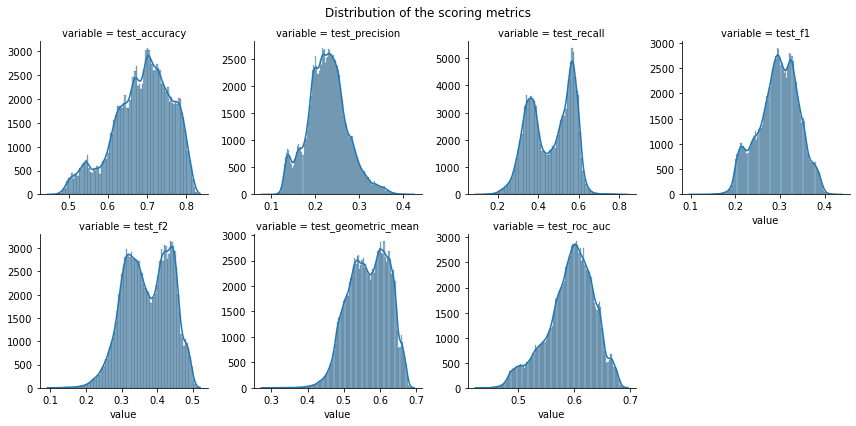

In [4]:
tmp = pd.melt(scores_data, value_vars=test_metrics)
g = sns.FacetGrid(data=tmp, col='variable', col_wrap=4, sharex=False, sharey=False)
del tmp
g.map(sns.histplot, 'value', kde=True)
plt.subplots_adjust(top=0.9)
g.fig.suptitle('Distribution of the scoring metrics')
plt.show()

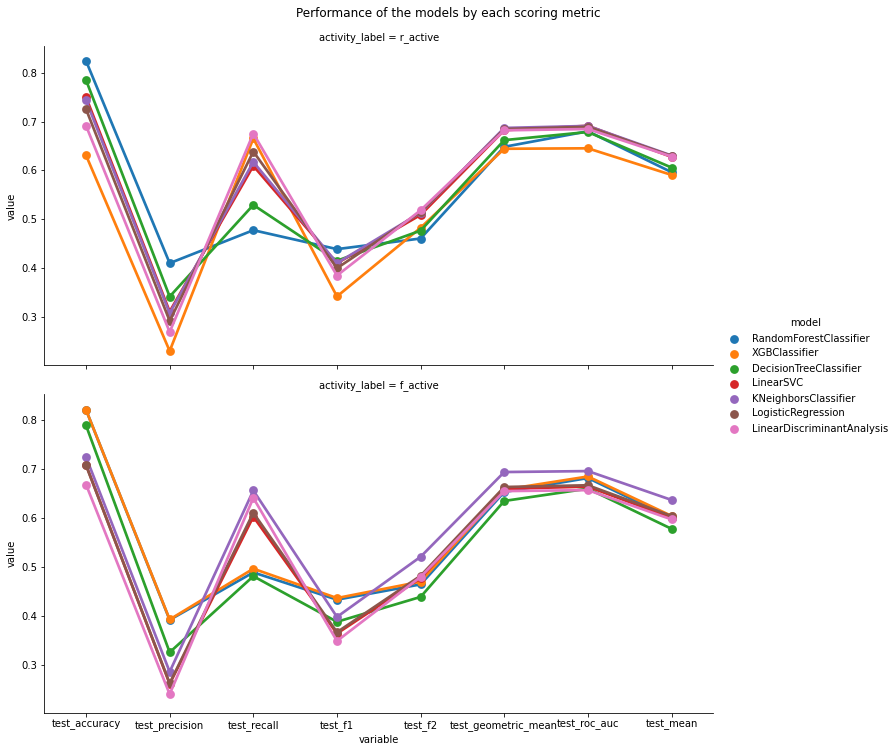

In [5]:
top = pd.melt(scores_data.groupby(['activity_label', 'model']).head(1), id_vars=['activity_label','model',*trainset], value_vars=[*test_metrics,'test_mean'])
sns.catplot(kind='point', data=top.sort_values('value', ascending=False), x='variable', y='value', hue='model', row='activity_label', aspect=2, order=[*test_metrics,'test_mean'])
plt.suptitle('Performance of the models by each scoring metric', y=1.02)
plt.savefig('test_performance.png', dpi=128)

<a id='finding'></a>
### Finding the best subset

In [6]:
# Dictionary: key == model_name, value == list of best descriptors
best_subset = {}

activity_label = 'f_active'
for i, row in scores_data.query('activity_label == @activity_label').groupby('model').head(1).iterrows():
    best_subset[row['model']] = [descriptor for descriptor in trainset if row[descriptor]]

<a id='reconstructing'></a>
### Reconstructing the top models

In [7]:
def get_model_by_name(model_name):
    if model_name == 'LogisticRegression':
        return LogisticRegression(solver='liblinear', random_state=13)
    elif model_name == 'LinearSVC':
        return CalibratedClassifierCV(LinearSVC(dual=False, random_state=13))
    elif model_name == 'RandomForestClassifier':
        return RandomForestClassifier(n_estimators=40, max_depth=6, random_state=13)
    elif model_name == 'KNeighborsClassifier':
        return KNeighborsClassifier(n_neighbors=5)
    elif model_name == 'XGBClassifier':
        return XGBClassifier(objective='reg:logistic', n_estimators=40, max_depth=3, eta=0.2, random_state=13)
    elif model_name == 'DecisionTreeClassifier':
        return DecisionTreeClassifier(max_depth=6, random_state=13)
    elif model_name == 'LinearDiscriminantAnalysis':
        return LinearDiscriminantAnalysis(solver='svd')
    return None

In [8]:
# Probabilities for the top models
train_data = pd.DataFrame()
test_data = pd.DataFrame()

# List of scores for the top models
scores_list = []
new_data = data.dropna(subset=trainset)

test_metrics = selected
train_metrics = [i.replace('test', 'train') for i in selected]
scoring_metrics = test_metrics + train_metrics

count = 0
for key, value in best_subset.items():
    model_name = key
    subset = value
    
    y = new_data[activity_label]
    X = new_data[subset]
            
    scaler = StandardScaler()
    pipe = make_pipeline(SMOTE(random_state=42), scaler, get_model_by_name(model_name))
        
    metrics_dict = {key: [] for key in scoring_metrics}
    
    skf = StratifiedKFold(n_splits=3, shuffle=True, random_state=1)
    for train_index, test_index in skf.split(X, y): 
        X_train, X_test = X.iloc[train_index], X.iloc[test_index]
        y_train, y_test = y.iloc[train_index], y.iloc[test_index] 
        model_fitted = pipe.fit(X_train, y_train)
        
        # Test predictions
        y_pred = model_fitted.predict(X_test)
        metrics_dict['test_f2'].append(fbeta_score(y_test, y_pred, beta=2)) # test_f2
        metrics_dict['test_geometric_mean'].append(geometric_mean_score(y_test, y_pred)) # test_geometric_mean
        metrics_dict['test_roc_auc'].append(roc_auc_score(y_test, y_pred)) # test_roc_auc
        
        # Training predictions
        y_pred = model_fitted.predict(X_train)
        metrics_dict['train_f2'].append(fbeta_score(y_train, y_pred, beta=2)) # train_f2
        metrics_dict['train_geometric_mean'].append(geometric_mean_score(y_train, y_pred)) # train_geometric_mean
        metrics_dict['train_roc_auc'].append(roc_auc_score(y_train, y_pred)) # train_roc_auc
    
    # Mean of the KFold scores
    scores = [np.mean(value) for value in metrics_dict.values()]
    scores_list.append([model_name, *scores])
    
    y_proba_train = model_fitted.predict_proba(X_train)
    train_data[model_name] = y_proba_train[:,1]

    y_proba_test = model_fitted.predict_proba(X_test)
    test_data[model_name] = y_proba_test[:,1]
    
    # Keep original indices
    test_data.index = X_test.index
    count+=1

columns = ['model', *scoring_metrics]
top_scores = pd.DataFrame(scores_list, columns=columns)
top_scores['test_mean'] = top_scores[test_metrics].mean(axis=1)
top_scores['train_mean'] = top_scores[train_metrics].mean(axis=1)

<a id='roc_curves'></a>
### ROC curves

,model,test_f2,test_geometric_mean,test_roc_auc,train_f2,train_geometric_mean,train_roc_auc,test_mean,train_mean
0,KNeighborsClassifier,0.470628,0.657756,0.664725,0.710476,0.833260,0.833740,0.597703,0.792492
1,XGBClassifier,0.479095,0.665992,0.680418,0.729217,0.844436,0.844927,0.608502,0.806193
2,LogisticRegression,0.468153,0.654057,0.658912,0.479542,0.662794,0.667065,0.593707,0.603134
3,LinearSVC,0.461524,0.650235,0.658530,0.479848,0.663562,0.668870,0.590096,0.604093
4,RandomForestClassifier,0.349241,0.557145,0.589880,0.644752,0.785605,0.787881,0.498755,0.739413
5,LinearDiscriminantAnalysis,0.445987,0.629983,0.633511,0.456656,0.638018,0.639120,0.569827,0.577931
6,DecisionTreeClassifier,0.366713,0.545916,0.551324,0.628336,0.759946,0.768506,0.487984,0.718929


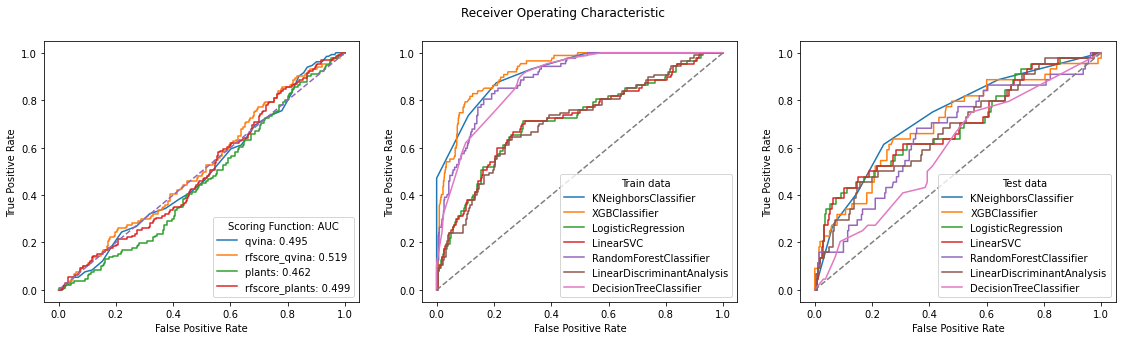

In [9]:
fig, ax = plt.subplots(ncols=3, figsize=(19.2, 4.8))

# Plot ROC curves for the docking scoring functions
for SF in docking_list:
    fpr, tpr, _ = roc_curve(data[activity_label].values, data[SF].values)
    ax[0].plot(fpr, tpr, label=f'{SF}: {auc(fpr, tpr):>.3f}')

# Plot ROC curves for the ML models
for model_name in best_subset.keys():
    fpr_train, tpr_train,_ = roc_curve(y_train, train_data[model_name])
    ax[1].plot(fpr_train, tpr_train, label=f'{model_name}')
    
    fpr_test, tpr_test,_ = roc_curve(y_test, test_data[model_name])
    ax[2].plot(fpr_test, tpr_test, label=f'{model_name}')

for i in range(3):
    # Plot a line
    ax[i].plot([0,1], [0,1], linestyle='--')
    ax[i].set_xlabel('False Positive Rate')
    ax[i].set_ylabel('True Positive Rate')

# Some legends
ax[0].legend(title='Scoring Function: AUC', loc='lower right')
ax[1].legend(title='Train data')
ax[2].legend(title='Test data')

plt.suptitle('Receiver Operating Characteristic')
plt.savefig('test_roc_curve.png', dpi=216)

# CONFERIR GRAFICO DO VINA

top_scores

<a id='supplementary'></a>
## Supplementary data
<a id='comparing'></a>
### Comparing models and labels

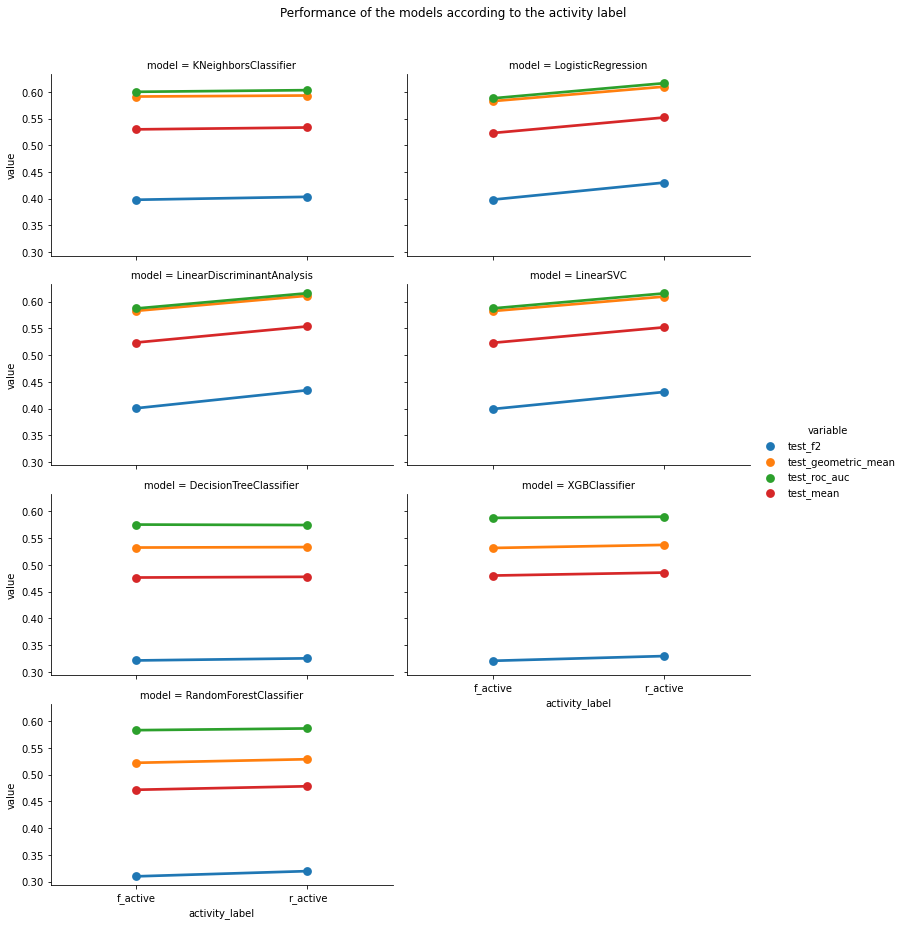

In [10]:
melt = pd.melt(scores_data, id_vars=['activity_label','model',*trainset], value_vars=[*test_metrics,'test_mean'])
sns.catplot(kind='point', data=melt, x='activity_label', y='value', hue='variable', col='model', col_wrap=2, height=3, aspect=1.75)
plt.suptitle('Performance of the models according to the activity label', y=1.02)
plt.show()

In [11]:
with pd.option_context('display.max_rows', None, 'display.max_columns', None):
    display(scores_data.groupby(['model','activity_label']).describe())

job_id                       \
                                            count    mean          std   
model                      activity_label                                
DecisionTreeClassifier     f_active        8840.0  9283.5  1786.421635   
                           r_active        8840.0  3095.5  1786.421635   
KNeighborsClassifier       f_active        8840.0  9280.5  1786.421635   
                           r_active        8840.0  3092.5  1786.421635   
LinearDiscriminantAnalysis f_active        8840.0  9284.5  1786.421635   
                           r_active        8840.0  3096.5  1786.421635   
LinearSVC                  f_active        8840.0  9281.5  1786.421635   
                           r_active        8840.0  3093.5  1786.421635   
LogisticRegression         f_active        8840.0  9278.5  1786.421635   
                           r_active        8840.0  3090.5  1786.421635   
RandomForestClassifier     f_active        8840.0  9279.5  1786.421635   
                           r_active        8840.0  3091.5  1786.421635   
XGBClassifier              f_active        8840.0  9282.5  1786.421635   
                           r_active        8840.0  3094.5  1786.421635   

                                                                              \
                                              min      25%     50%       75%   
model                      activity_label                                      
DecisionTreeClassifier     f_active        6193.0  7738.25  9283.5  10828.75   
                           r_active           5.0  1550.25  3095.5   4640.75   
KNeighborsClassifier       f_active        6190.0  7735.25  9280.5  10825.75   
                           r_active           2.0  1547.25  3092.5   4637.75   
LinearDiscriminantAnalysis f_active        6194.0  7739.25  9284.5  10829.75   
                           r_active           6.0  1551.25  3096.5   4641.75   
LinearSVC                  f_active        6191.0  7736.25  9281.5  10826.75   
                           r_active           3.0  1548.25  3093.5   4638.75   
LogisticRegression         f_active        6188.0  7733.25  9278.5  10823.75   
                           r_active           0.0  1545.25  3090.5   4635.75   
RandomForestClassifier     f_active        6189.0  7734.25  9279.5  10824.75   
                           r_active           1.0  1546.25  3091.5   4636.75   
XGBClassifier              f_active        6192.0  7737.25  9282.5  10827.75   
                           r_active           4.0  1549.25  3094.5   4639.75   

                                                   test_accuracy            \
                                               max         count      mean   
model                      activity_label                                    
DecisionTreeClassifier     f_active        12374.0        8840.0  0.725413   
                           r_active         6186.0        8840.0  0.720027   
KNeighborsClassifier       f_active        12371.0        8840.0  0.661659   
                           r_active         6183.0        8840.0  0.671028   
LinearDiscriminantAnalysis f_active        12375.0        8840.0  0.614199   
                           r_active         6187.0        8840.0  0.647911   
LinearSVC                  f_active        12372.0        8840.0  0.618598   
                           r_active         6184.0        8840.0  0.654229   
LogisticRegression         f_active        12369.0        8840.0  0.622492   
                           r_active         6181.0        8840.0  0.658780   
RandomForestClassifier     f_active        12370.0        8840.0  0.763680   
                           r_active         6182.0        8840.0  0.760370   
XGBClassifier              f_active        12373.0        8840.0  0.760510   
                           r_active         6185.0        8840.0  0.755576   

                                                                         \
                     

<a id='docking'></a>
### Docking scores and performance increment

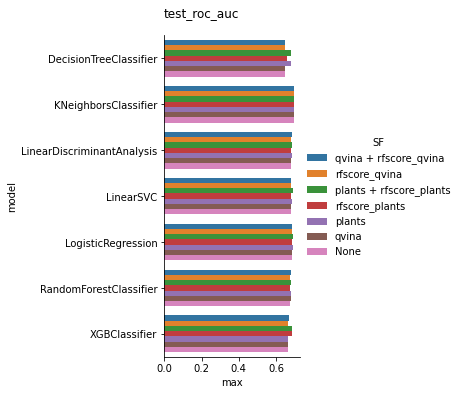

In [12]:
'''
combinations = [('qvina', 'rfscore_qvina'),
                ('plants', 'rfscore_plants'),
                ('qvina', 'rfscore_qvina', 'plants'),
                ('qvina', 'rfscore_qvina', 'rfscore_plants'),
                ('qvina', 'plants', 'rfscore_plants'),
                ('rfscore_qvina', 'plants', 'rfscore_plants'),
                ('qvina', 'rfscore_qvina', 'plants', 'rfscore_plants')]
'''

df = scores_data.query('qvina == 0 and rfscore_qvina == 0 and plants == 0 and rfscore_plants == 0').groupby('model').describe()['test_roc_auc'][['mean','max']]
df['SF'] = 'None'

tmp = scores_data.query('rfscore_qvina == 0 and plants == 0 and rfscore_plants == 0').groupby('model').describe()['test_roc_auc'][['mean','max']]
tmp['SF'] = 'qvina'
df = df.append(tmp)

tmp = scores_data.query('qvina == 0 and plants == 0 and rfscore_plants == 0').groupby('model').describe()['test_roc_auc'][['mean','max']]
tmp['SF'] = 'rfscore_qvina'
df = df.append(tmp)

tmp = scores_data.query('plants == 0 and rfscore_plants == 0').groupby('model').describe()['test_roc_auc'][['mean','max']]
tmp['SF'] = 'qvina + rfscore_qvina'
df = df.append(tmp)

tmp = scores_data.query('qvina == 0 and rfscore_qvina == 0 and rfscore_plants == 0').groupby('model').describe()['test_roc_auc'][['mean','max']]
tmp['SF'] = 'plants'
df = df.append(tmp)

tmp = scores_data.query('qvina == 0 and rfscore_qvina == 0 and plants == 0').groupby('model').describe()['test_roc_auc'][['mean','max']]
tmp['SF'] = 'rfscore_plants'
df = df.append(tmp)

tmp = scores_data.query('qvina == 0 and rfscore_qvina == 0').groupby('model').describe()['test_roc_auc'][['mean','max']]
tmp['SF'] = 'plants + rfscore_plants'
df = df.append(tmp)

del tmp
df.reset_index(inplace=True)
df.sort_values(['model','mean','max'], inplace=True)

#compare = pd.melt(df, id_vars=['model','SF'], value_vars=['mean','max'])
sns.catplot(kind='bar', data=df, y='model', x='max', hue='SF')
plt.suptitle('test_roc_auc', y=1.05)
plt.show()

The barplot above indicates the performance scores don't increase when docking scores are taken into account. In fact, all models' average scores, and most models' top scores, are higher when only the molecular descriptors are evaluated, although "qvina" and "qvina" + "rfscore_qvina" consistently have higher scores for all models.

<a id='top_descriptors'></a>
### Top descriptors

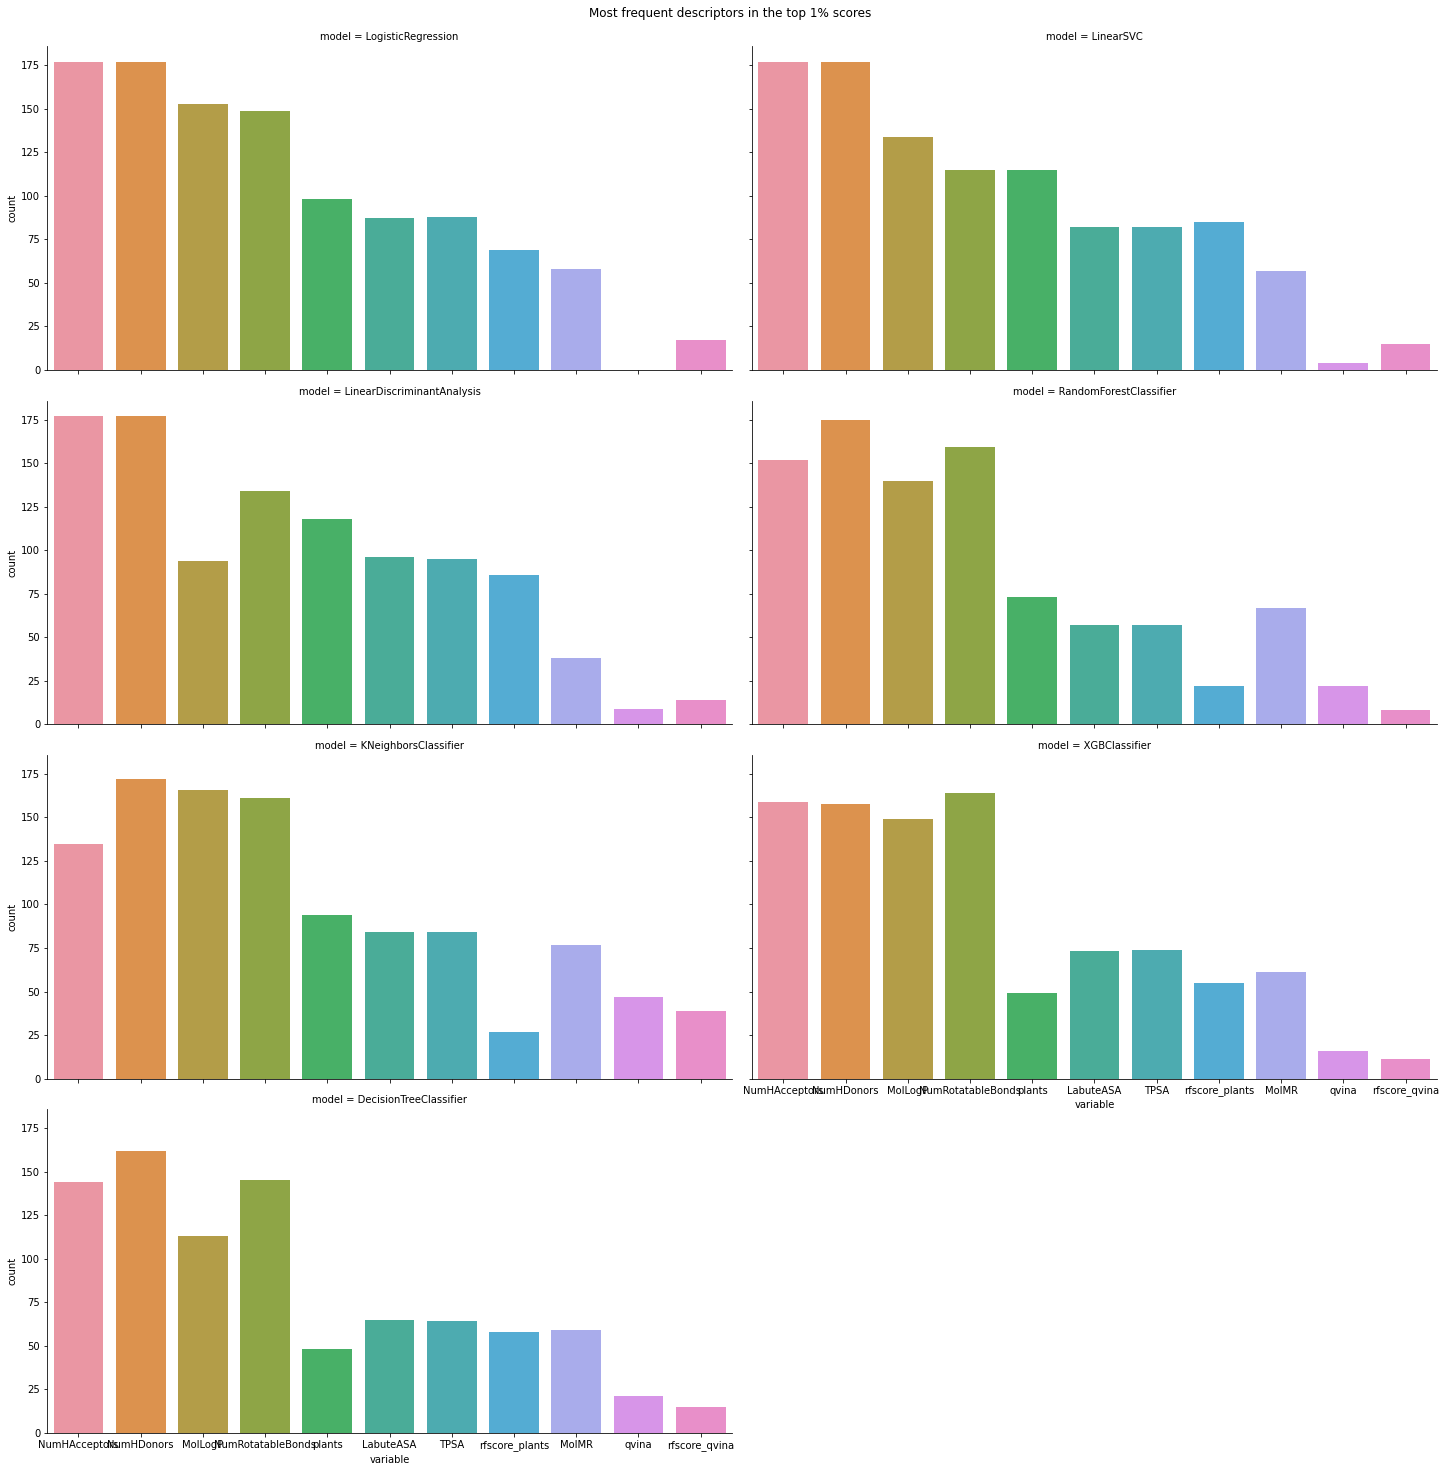

In [27]:
# How frequently does each descriptor appear in the top 1% scores for each model?
N = np.ceil(0.01 * len(scores_data.query('model == "LogisticRegression"')))
tmp = pd.melt(scores_data, id_vars=[*test_metrics,'activity_label','model','test_mean'], value_vars=trainset, value_name='count')
count = pd.DataFrame(tmp.groupby(['model','variable']).head(N).groupby(['model','variable'])['count'].value_counts())
del tmp

count.index.names = ['model','variable','value']
count.reset_index(level=[0,1,2], inplace=True)
count = count.query('value == 1').sort_values('count', ascending=False)
count.drop('value', axis=1, inplace=True)

g = sns.catplot(kind='bar', data=count, x='variable', y='count', col='model', col_wrap=2, aspect=2)

# Set title
plt.suptitle('Most frequent descriptors in the top 1% scores', y=1.02)
plt.show()

In [14]:
print('The frequency count shows the most recurring descriptors in each model\'s top 1% results are: ')
for key, value in best_subset.items():
    print(key, value)

The frequency count shows the most recurring descriptors in each model's top 1% results are: 
KNeighborsClassifier ['MolMR', 'NumRotatableBonds', 'NumHAcceptors', 'NumHDonors', 'MolLogP', 'qvina']
XGBClassifier ['NumRotatableBonds', 'NumHAcceptors', 'NumHDonors', 'TPSA', 'LabuteASA', 'MolLogP', 'rfscore_plants']
LogisticRegression ['MolMR', 'NumRotatableBonds', 'NumHAcceptors', 'NumHDonors', 'MolLogP', 'rfscore_qvina']
LinearSVC ['MolMR', 'NumHAcceptors', 'NumHDonors', 'MolLogP', 'rfscore_qvina']
RandomForestClassifier ['MolMR', 'NumRotatableBonds', 'NumHAcceptors', 'NumHDonors', 'MolLogP', 'qvina']
LinearDiscriminantAnalysis ['MolMR', 'NumRotatableBonds', 'NumHAcceptors', 'NumHDonors', 'qvina', 'rfscore_qvina']
DecisionTreeClassifier ['NumRotatableBonds', 'NumHAcceptors', 'LabuteASA', 'MolLogP', 'rfscore_plants']


<a id='confusion_matrix'></a>
### Confusion matrix for the best model

In [15]:
# Confusion matrix

from sklearn.metrics import confusion_matrix, log_loss

model_name = top_scores.sort_values('test_mean', ascending=False).iloc[0]['model']
subset = best_subset[model_name]

y = new_data[activity_label]
X = new_data[subset]

scaler = StandardScaler()
pipe = make_pipeline(SMOTE(random_state=42), scaler, XGBClassifier(objective='reg:logistic', random_state=13))

skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=1)
for train_index, test_index in skf.split(X, y): 
    X_train, X_test = X.iloc[train_index], X.iloc[test_index] 
    y_train, y_test = y.iloc[train_index], y.iloc[test_index] 
    break
    
pipe = pipe.fit(X_train, y_train)
y_pred = pipe.predict(X_test)
y_proba = pipe.predict_proba(X_test)[:, 1]

#     Predicted   inactive |  active
# Actual 
# inactive      |    TN    |    FP    | 
# active        |    FN    |    TP    | 

conf_matrix = confusion_matrix(y_test, y_pred, normalize='true')
matrix = pd.DataFrame(conf_matrix)

print(model_name)
print(f'RMSE: {np.linalg.norm(y_proba - y_test) / np.sqrt(len(y_test)):.4f}')
print(f'log_loss: {log_loss(y_test, y_proba):.4f}')
matrix

XGBClassifier
RMSE: 0.3732
log_loss: 0.5174


,0,1
0,0.865031,0.134969
1,0.384615,0.615385


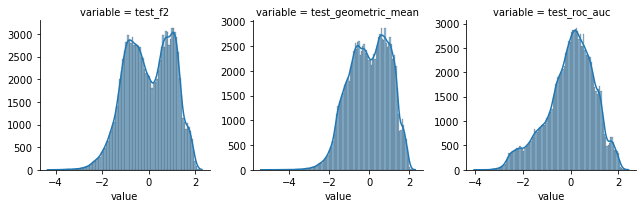

In [16]:
df = scores_data.copy()
df[test_metrics] = StandardScaler().fit_transform(scores_data[test_metrics])
tmp = pd.melt(df, value_vars=test_metrics)
g = sns.FacetGrid(data=tmp, col='variable', col_wrap=4, sharex=False, sharey=False)
del tmp
g.map(sns.histplot, 'value', kde=True)

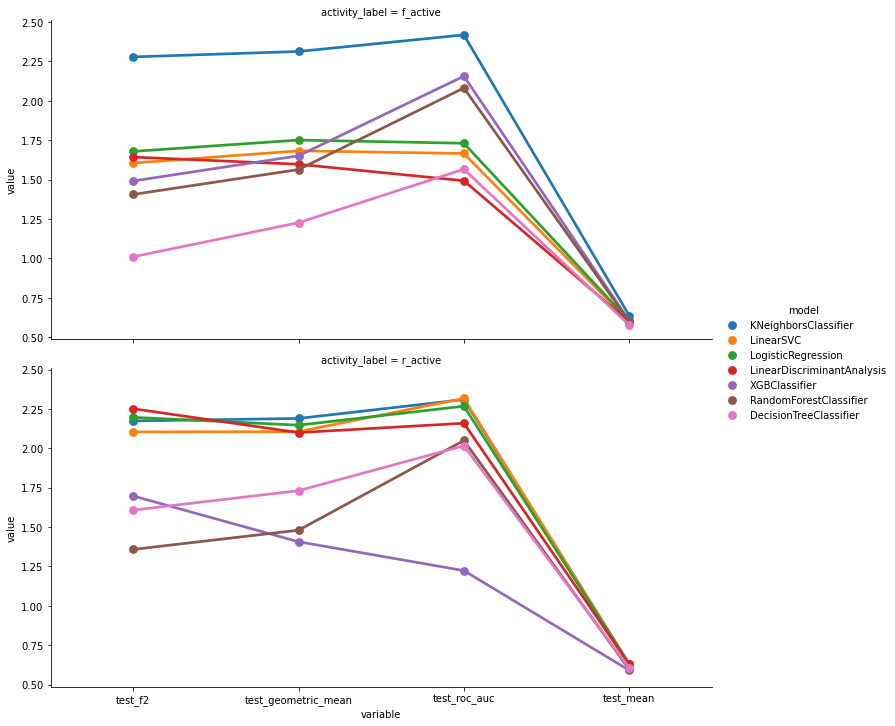

In [17]:
top = pd.melt(df.groupby(['activity_label', 'model']).head(1), id_vars=['activity_label','model',*trainset], value_vars=[*test_metrics,'test_mean'])
sns.catplot(kind='point', data=top.sort_values('value', ascending=False), x='variable', y='value', hue='model', row='activity_label', aspect=2, order=[*test_metrics,'test_mean'])
plt.savefig('test_performance.png', dpi=216)

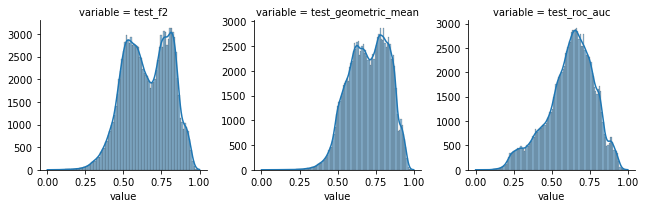

In [18]:
df = scores_data.copy()
df[test_metrics] = MinMaxScaler().fit_transform(scores_data[test_metrics])
tmp = pd.melt(df, value_vars=test_metrics)
g = sns.FacetGrid(data=tmp, col='variable', col_wrap=4, sharex=False, sharey=False)
del tmp
g.map(sns.histplot, 'value', kde=True)

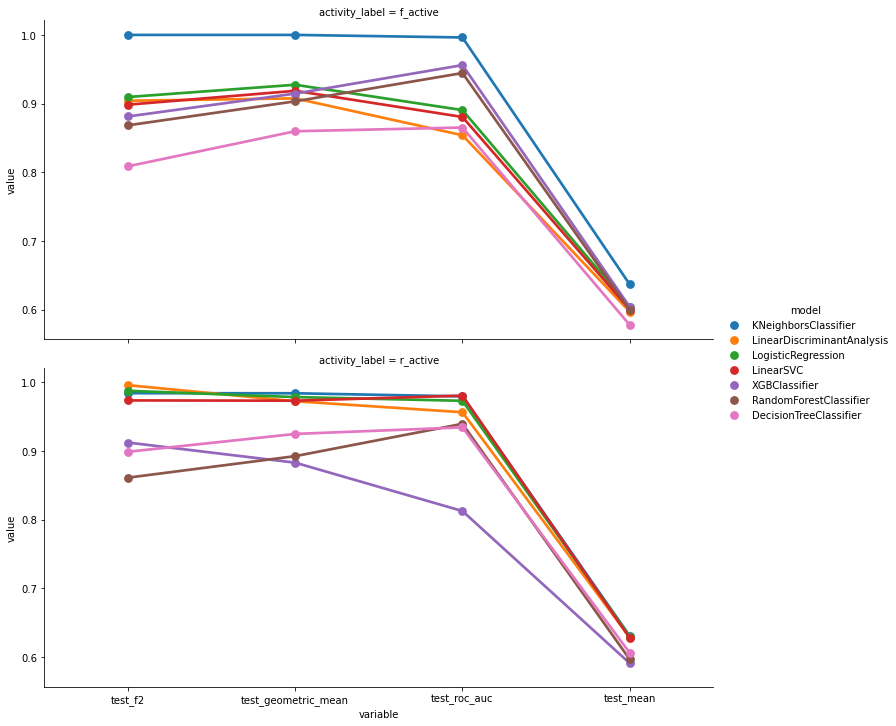

In [19]:
top = pd.melt(df.groupby(['activity_label', 'model']).head(1), id_vars=['activity_label','model',*trainset], value_vars=[*test_metrics,'test_mean'])
sns.catplot(kind='point', data=top.sort_values('value', ascending=False), x='variable', y='value', hue='model', row='activity_label', aspect=2, order=[*test_metrics,'test_mean'])
plt.savefig('test_performance.png', dpi=216)

<a id='regression'></a>
### Regression plots

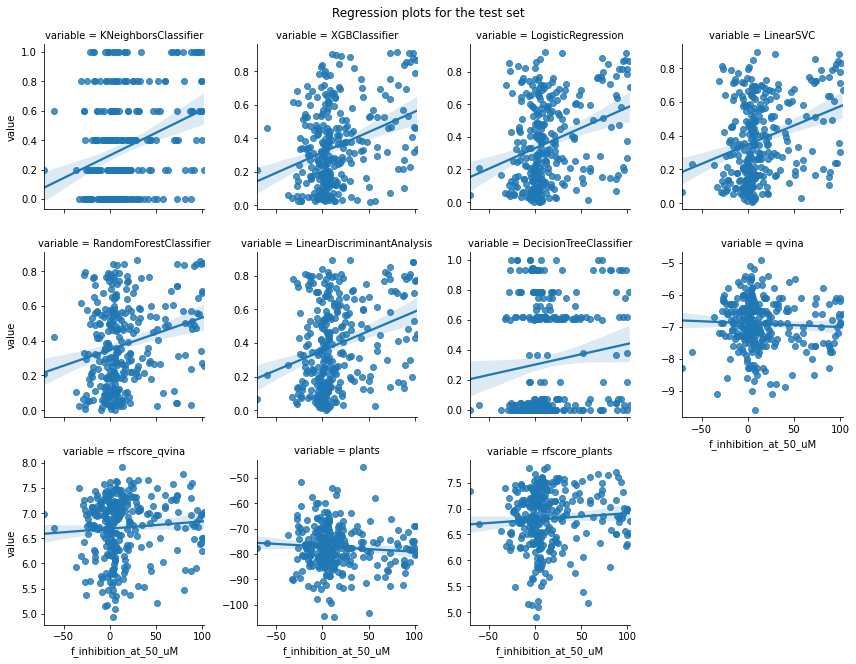

In [28]:
from scipy.stats import spearmanr

test_data['CID'] = data.loc[test_data.index]['CID']
tmp = pd.melt(test_data, id_vars=['CID'], value_vars=test_data.columns[:-1])
tmp = tmp.append(pd.melt(data.loc[test_data.index], id_vars=['CID'], value_vars=['qvina','rfscore_qvina','plants','rfscore_plants']))
df_tidy = pd.merge(data.loc[test_data.index][['CID','r_inhibition_at_50_uM','f_inhibition_at_50_uM']], tmp, on=['CID'])

g = sns.FacetGrid(data=df_tidy, col='variable', col_wrap=4, sharey=False)
g.map(sns.regplot, 'f_inhibition_at_50_uM', 'value')

# Set title
plt.suptitle('Regression plots for the test set', y=1.02)
plt.show()

<a id='correlations'></a>
### Correlations

In [21]:
# Pearson correlations with inhibitions
df_tidy.pivot_table(index=['CID','r_inhibition_at_50_uM','f_inhibition_at_50_uM'], 
                    columns='variable',values='value').reset_index().corr(method='pearson')[['r_inhibition_at_50_uM','f_inhibition_at_50_uM']]

variable,r_inhibition_at_50_uM,f_inhibition_at_50_uM
variable,,
r_inhibition_at_50_uM,1.000000,0.778507
f_inhibition_at_50_uM,0.778507,1.000000
DecisionTreeClassifier,0.163881,0.143576
KNeighborsClassifier,0.372459,0.313170
LinearDiscriminantAnalysis,0.353061,0.311370
LinearSVC,0.344706,0.320076
LogisticRegression,0.352087,0.325436
RandomForestClassifier,0.322968,0.248891
XGBClassifier,0.355797,0.335278


In [22]:
# Spearman correlations with inhibitions
df_tidy.pivot_table(index=['CID','r_inhibition_at_50_uM','f_inhibition_at_50_uM'], 
                    columns='variable',values='value').reset_index().corr(method='spearman')[['r_inhibition_at_50_uM','f_inhibition_at_50_uM']]

variable,r_inhibition_at_50_uM,f_inhibition_at_50_uM
variable,,
r_inhibition_at_50_uM,1.000000,0.635991
f_inhibition_at_50_uM,0.635991,1.000000
DecisionTreeClassifier,0.172008,0.133323
KNeighborsClassifier,0.217228,0.251521
LinearDiscriminantAnalysis,0.265387,0.270491
LinearSVC,0.262436,0.277881
LogisticRegression,0.259869,0.278866
RandomForestClassifier,0.253188,0.204439
XGBClassifier,0.259848,0.257881
